<h1 align="center">
    ANN and Gaussian Process System Identification
</h1>

### Calling the dataset

In this part, we need to call the given dataset, namely `disk-measurement-dataset-1.npz` for training and validation datasets and `disk-measurment-dataset-2.npz` for simulation. However, this data need to be transformed into time-series data, so that the model can be trained in line with NARX representations model, i.e. $X = [y_{t-1} \ldots y_{t-n_a} \, u_t \ldots u_{t-n_b}]$ and $y = y_t$, where $X$ is the input data, $y$ is the output data, $n_a$ and $n_b$ are the time delay w.r.t. the output and input data.

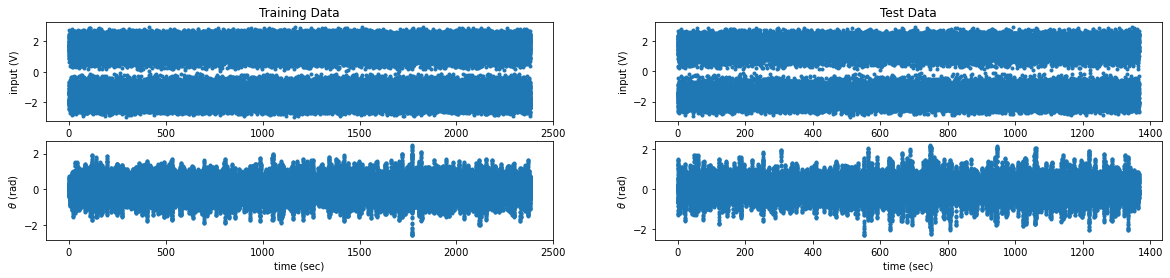

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Training and Validation data
out = np.load('data_sets/disk-measurement-dataset-1.npz') 
u = np.float32(out['u']) #inputs
th = np.float32(out['th']) #outputs
t = np.float32(out['t'])#time vector

# Simulation (test) data
test_data = np.load('data_sets/disk-measurement-dataset-2.npz') 
u_test = np.float32(test_data['u']) # inputs
th_test = np.float32(test_data['th']) # outputs
t_test = np.float32(test_data['t'])# time vector

def make_dataset(ulist,ylist,na,nb):
    '''
    Creating the training data for NARX system identification method
    --------------------------------------------------------------------
    Inputs:
        ulist: ndarray of input signals
        ylist: ndarray of output signals
        na: number of delays in the output signal
        nb: number of delays in the input signal
    Outputs: (Xdata, Ydata)
        Xdata: input data (ndarray of shape (length of ulist, na+nb))
        Ydata: output data (ndarray of shape (length of ylist, 1))
    '''
    Xdata = []
    Ydata = []
    #for loop over the data:
    for k in range(max(na,nb),len(ulist)): 
        Xdata.append(np.concatenate([ulist[k-nb:k],ylist[k-na:k]])) 
        Ydata.append(ylist[k]) 
    return np.array(Xdata, dtype=np.float32), np.array(Ydata, dtype=np.float32)

# Plotting the dataset
plt.figure(figsize=(20,4))
plt.subplot(2,2,1)
plt.plot(t,u,'.')
plt.xlabel('time (sec)')
plt.ylabel('input (V)')
plt.title('Training Data')
plt.subplot(2,2,2)
plt.plot(t_test,u_test,'.')
plt.xlabel('time (sec)')
plt.ylabel('input (V)')
plt.title('Test Data')
plt.subplot(2,2,3)
plt.plot(t,th,'.')
plt.xlabel('time (sec)')
plt.ylabel('$\\theta$ (rad)')
plt.subplot(2,2,4)
plt.plot(t_test,th_test,'.')
plt.xlabel('time (sec)')
plt.ylabel('$\\theta$ (rad)')
plt.show()

## 1. Artificial Neural Network for System Identification
To start with Neural Network, we need to make the model by utilising the linear layers. The activation function for this purpose would be ReLU, as it is faster than using Tanh and Sigmoid. However, using ReLU has its own downside, which is the discontinuity at x = 0 (undescribeable values when it reach 0 at its derivative function or gradient). Designing the model and the training function would mean that the 

In [2]:
import torch.nn as nn
import torch

'''Linear net with 2 hidden layer'''
class NARX_NN(nn.Module):
    def __init__(self,in_,hidden_1,hidden_2):
        super(NARX_NN, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_,hidden_1, bias=True, dtype=torch.float32),
            nn.ReLU(True),
            nn.Linear(hidden_1, hidden_2, bias=True, dtype=torch.float32),
            nn.ReLU(True),
            nn.Linear(hidden_2, 1, bias=True, dtype=torch.float32)
        )

    def forward(self,x):
        u = self.layer(x)[:,0]
        return u
        
def train(model,optimizer,criterion,epochs,Xtrain,Ytrain,Xval,Yval):
    model.train()
    train_loss = []
    val_loss =[]
    for epoch in range(epochs):
        Ypred = model(Xtrain.to(torch.device('mps')))
        loss_train = criterion(Ypred.to(torch.device('mps')),Ytrain.to(torch.device('mps')))
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        train_loss.append(loss_train.item())

        with torch.no_grad():
            model.eval()
            Ypred = model(Xval.to(torch.device('mps')))
            loss_val = criterion(Ypred.to(torch.device('mps')), Yval)
            val_loss.append(loss_val.item())

        # if (epoch+1)%200 == 0:
        #     print(f'epoch = {epoch+1}, Train_loss = {loss_train.item(): .4f}, Val_loss = {loss_val.item(): .4f}')
    return train_loss, val_loss 

After defining the model and its training functions, we are now ready to train the Artificial Neural Network by making the train, validation and test data for NARX representation. This can be achieved by the `make_dataset` function and adjusting the suitable $n_a$ and $n_b$ for the dynamics, resulting in `Xdata`, `Ydata`, `Xtest`, and `Ytest`. The `Xdata` and `Ydata` will then be splitted 80/20 for training and validation respectively, where the test data will be the same.

Since the training will be faster on GPU, we move all of the `Xtrain`, `Ytrain`, `Xval`, `Yval`, `Xtest`, and `Ytest` data to the GPU alongside with moving the model as well. Thus, all the ingredients are complete and the training will take place at GPU. The hyper-parameters that we can control here are the epochs, optimizer algorithm, learning-rate and loss function. In this training process, we opt for Adam optimizer algorithm and Mean-squared Error (MSE) loss function. The rest will be tuned after several trials and errors as needed.

In [3]:
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.nn import MSELoss

Xdata, Ydata = make_dataset(u,th,2,1) # For training data
Xtest, Ytest = make_dataset(u_test, th_test, 2, 1)    # For simulation data
Xtrain, Xval, Ytrain, Yval = train_test_split(Xdata,Ydata)

if torch.backends.mps.is_available():
    Xtrain,Xval,Ytrain,Yval = [torch.as_tensor(x).to(torch.device('mps')) for x in [Xtrain, Xval, Ytrain, Yval]]
    Xtest, Ytest = [torch.as_tensor(x).to(torch.device('mps')) for x in [Xtest, Ytest]]

model = NARX_NN(Xtrain.shape[1],32,16).to(torch.device('mps'))
learning_rate = 2e-3
optimizer, criterion = Adam(model.parameters(), lr=learning_rate), MSELoss()
train_loss, val_loss = train(model, optimizer, criterion, 10000, Xtrain, Ytrain, Xval, Yval)
torch.save(model.state_dict(), "model/NARX_NN_best.pth")    # Saving the best model

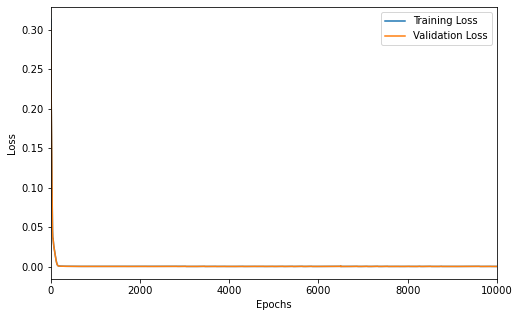

In [4]:
# Plotting the training and validation loss
plt.figure(figsize=(8,5)) 
plt.plot(np.linspace(1,10000,num=10000), train_loss, label="Training Loss") 
plt.plot(np.linspace(1,10000,num=10000), val_loss, label="Validation Loss") 
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.xlim(left=0, right=10001)
plt.show() 

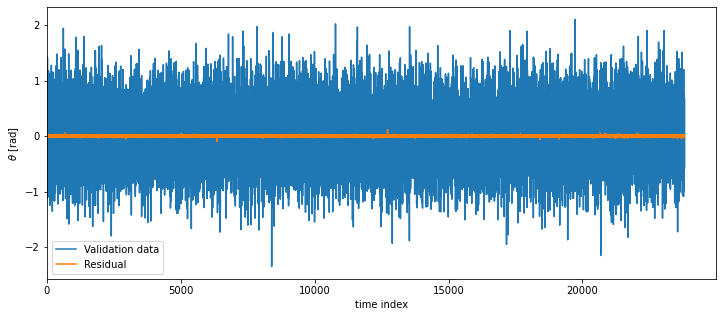

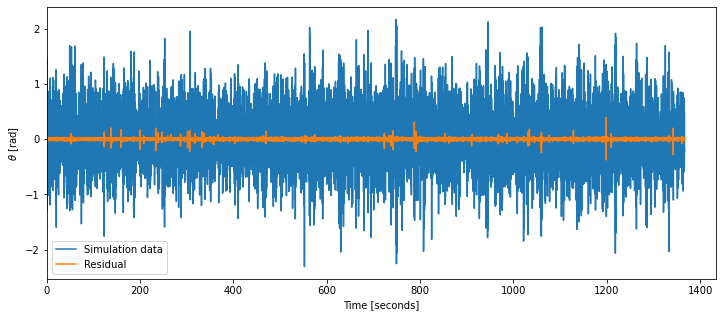

===========================NN Summary===========================
===========================Prediction===========================
RMS =  0.0107 || NRMS =  0.0217
===========================Simulation===========================
RMS =  0.0133 || NRMS =  0.0270


In [5]:
with torch.no_grad():

    # Ytrain_pred = model(Xtrain.to(torch.device('mps'))) 
    # res_train = Ytrain_pred - Ytrain 
    # plt.figure(figsize=(12,5)) 
    # plt.plot(Ytrain.cpu().numpy(), label="Training data") 
    # plt.plot(res_train.cpu().numpy(), label="Residual") 
    # plt.xlabel('time index'); plt.ylabel(r'$\theta$ [rad]'); plt.legend()
    # plt.show() 

    Yval_pred = model(Xval.to(torch.device("mps"))) 
    res_val = Yval_pred - Yval 
    plt.figure(figsize=(12,5)) 
    plt.plot(Yval.cpu().numpy(), label="Validation data") 
    plt.plot(res_val.cpu().numpy(), label="Residual") 
    plt.xlabel('time index'); plt.ylabel(r'$\theta$ [rad]'); plt.legend(); plt.xlim(left=0)
    plt.show() 

    Ysim = model(Xtest.to(torch.device('mps'))) 
    res_sim = Ysim - Ytest 
    plt.figure(figsize=(12,5)) 
    plt.plot(t_test[:54658],Ytest.cpu().numpy(), label="Simulation data")
    plt.plot(t_test[:54658],res_sim.cpu().numpy(), label="Residual") 
    plt.xlabel('Time [seconds]'); plt.ylabel(r'$\theta$ [rad]'); plt.legend(); plt.xlim(left=0)
    plt.show() 
    
    print("===========================NN Summary===========================")
    print("===========================Prediction===========================")
    print(f'RMS = {np.mean((res_val.cpu().numpy()**2))**0.5: .4f} || NRMS = {np.mean((res_val.cpu().numpy()**2))**0.5/np.std(Ytest.cpu().numpy()): .4f}')
    print("===========================Simulation===========================")
    print(f'RMS = {np.mean((res_sim.cpu().numpy()**2))**0.5: .4f} || NRMS = {np.mean((res_sim.cpu().numpy()**2))**0.5/np.std(Ytest.cpu().numpy()): .4f}')
    

KeyboardInterrupt: 

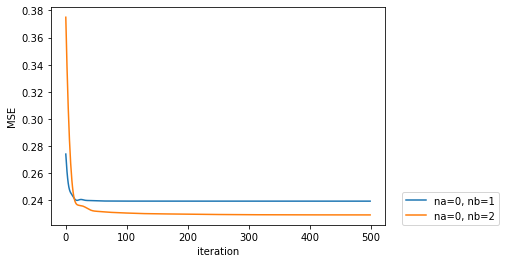

In [6]:
for na in [0,1,2,3]:
    for nb in [0,1,2,3]:
        if na + nb == 0:
            continue
        Xdata, Ydata = make_dataset(u,th,na,nb)
        Xtrain,Xval,Ytrain,Yval = train_test_split(Xdata,Ydata)
        
        if torch.backends.mps.is_available():
            Xtrain,Xval,Ytrain,Yval = [torch.as_tensor(x).to(torch.device('mps')) for x in [Xtrain, Xval, Ytrain, Yval]]
            #print(Xtrain.shape)

        model = NARX_NN(Xtrain.shape[1],32,16)
        model = model.to(torch.device('mps'))
        learning_rate = 1e-3
        optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
        criterion = nn.MSELoss()

        train_loss, val_loss = train(model, optimizer, criterion, 500, Xtrain, Ytrain, Xval, Yval)

        #plt.plot(train_loss)
        plt.plot(val_loss,label=f'na={na}, nb={nb}')
        plt.xlabel('iteration')
        plt.ylabel('MSE')
        plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

## 2. Gaussian Process
For the NARX-Gaussian Process, we can use the built-in function from Scikit-learn. Tuning the GP would mean that we are trying to model the dynamics by tweaking the $n_a$ and $n_b$ for the desired dynamics and also the kernel to explore all of the data-points. In this task, we can achieve the NARX with $n_a=2$, $n_b=1$ and the kernel composed by adding a radial basis function/squared-exponential (RBF) with the white noise (WhiteKernel) kernels. After the training `reg.fit()`, we can then save the trained GP model with `joblib.dump()` function to reload it for the future.

In [7]:
'''na = 2, nb = 1'''
'''GP kernel: RBF(function) and White(noise)'''
from sklearn.base import clone
from sklearn.model_selection import train_test_split
# from skopt import gp_minimize
# from skopt.learning import GaussianProcessRegressor
# from skopt.learning.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import joblib

Xdata, Ydata = make_dataset(u, th, 2, 1)
Xtest, Ytest = make_dataset(u_test, th_test, 2, 1)
Xtrain,Xval,Ytrain,Yval = train_test_split(Xdata,Ydata)
Xtrain_sample,Xval_sample,Ytrain_sample,Yval_sample = Xtrain[:10000,:],Xval[:2000,:],Ytrain[:10000],Yval[:2000]        

# ker = RBF(0.1) + WhiteKernel(0.01)
# reg = GaussianProcessRegressor(ker,n_restarts_optimizer=10)
# reg.fit(Xtrain,Ytrain)  # Takes 238.39 minutes to train
# joblib.dump(reg, "model/gp_reg_10k_bayes.pkl") # saving GP regression model
reg = joblib.load("model/gp_reg_10k.pkl") # Loading GP regression model


After training a GP model and save it, we can plot the prediction and simulation of

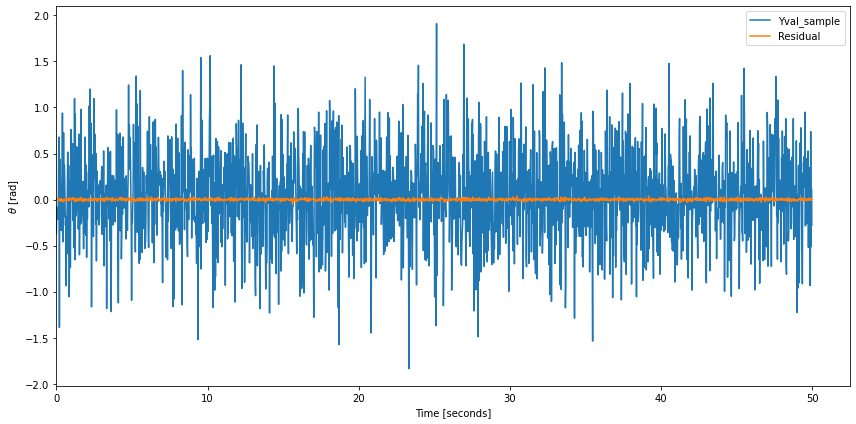

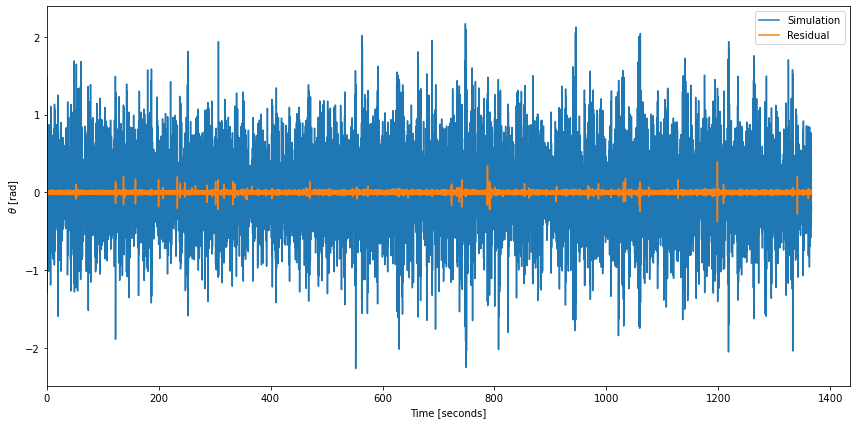

'===========================GP Summary==========================='

<IPython.core.display.Latex object>

'===========================Prediction==========================='

<IPython.core.display.Latex object>

'===========================Simulation==========================='

<IPython.core.display.Latex object>

In [8]:
from IPython.display import display, Latex
%matplotlib inline


Yval_p, Yval_p_std = reg.predict(Xval_sample,return_std=True)
Ysim, Ysim_std = reg.predict(Xtest, return_std=True)

res = Yval_p-Yval_sample
plt.figure(figsize=(12,6))
plt.plot(t[:2000],Yval_sample,label='Yval_sample')
plt.plot(t[:2000],res,label='Residual')
plt.xlabel("Time [seconds]"); plt.ylabel(r"$\theta$ [rad]")
plt.xlim(left=0)
plt.legend()
plt.tight_layout()
plt.show()

sim = Ysim - Ytest
plt.figure(figsize=(12,6))
plt.plot(t_test[:54658],Ysim,label='Simulation')
plt.plot(t_test[:54658],sim,label='Residual')
plt.xlabel("Time [seconds]"); plt.ylabel(r"$\theta$ [rad]")
plt.xlim(left=0)
plt.legend()
plt.tight_layout()
plt.show()

display('===========================GP Summary===========================')
display(Latex(f"Marginal log-likelihood = {reg.log_marginal_likelihood(): .4f} || $R^2$ = {reg.score(Xtest, Ytest): .4f}"))
display('===========================Prediction===========================')
display(Latex(f'RMS = {np.mean((res**2))**0.5: .4f} || NRMS = {np.mean((res**2))**0.5/np.std(Yval_sample): .4f}'))
display('===========================Simulation===========================')
display(Latex(f'RMS = {np.mean((sim**2))**0.5: .4f} || NRMS = {np.mean((sim**2))**0.5/np.std(Ytest): .4f}'))
